Initial setup

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader #used to iterate through data and use it in our code.
from torchvision import datasets # we will be using vision datasets. pytorch has domain specific datasets like text, vision, audio
from torchvision.transforms import ToTensor

# Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
# Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

#what does toTensor mean? tensor is a multidimensional array in pytorch
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)




Using loaded Datasets in our code through dataloader.

In [5]:
batch_size = 64
# Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
#we don't use numpy here?

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") #what are these four dimensions?
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(X)
    print(y) #labels range from 0 to 9 for a 10 class classification
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0.,

Creating our model
1. setting up which device to use
2. defining model parameters
3. 28*28 is a 2-d image's pixel dimensions. so in total there are 784 pixels, each being a number?
4. Flattening of input before passing to the neural net:
a. Dense layers expect a 1D input vector, so we need to flatten multi-dimensional data before passing it to them.
b. flattening converts multi dimensional data into a single dimension.
c. flattening preserves all the original information; it just reshapes it


In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):#we create a class that inherits from nn.Module.
    def __init__(self): #constructor of our class.
        super().__init__() #This calls the constructor of the parent class
        self.flatten = nn.Flatten() #a function to flatten the input.
        self.linear_relu_stack = nn.Sequential( # this is the core neural network function.
            #we have a layer without any units, just for activation of prev layer. it simplifies calculations.
            nn.Linear(28*28, 512), #first parameter means input size and second means no of units in the layer
            nn.ReLU(),
            nn.Linear(512, 512),# units in prev layer=input size of cur layer.
            nn.ReLU(),
            nn.Linear(512, 10) # finally we have 10 neurons in the last layer.
        )
    #specify how data will pass through the network(forward pass) in the forward function.
    # ie. first it will be flattened and the output would be the output of linear_relu_stack function.
    def forward(self, x): 
        x = self.flatten(x)
        logits = self.linear_relu_stack(x) # This passes the flattened input through the stack of linear and ReLU layers.
        return logits

model = NeuralNetwork().to(device)#To accelerate operations in the neural network, we move it to the GPU or MPS if available.
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Optimizing a model for training:
1. optimizer
2. loss function

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Training:
In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.
- Does it backpropagate for each batch?
a. both the forward pass and the backpropagation happen on a per-batch basis aka mini-batch gradient descent.
b. Immediately after calculating the loss for a batch, backpropagation is performed for that same batch.
c. This process (forward pass, loss calculation, backpropagation, parameter update) is repeated for each batch in an epoch.
Again, what's the advantage of using batches?
More frequent updates allow for faster convergence.
Provides a balance between the efficiency of batch gradient descent and the noise of stochastic gradient descent.
Allows for better generalization as the noise in the updates can help escape local minima.
In pytorch, you can customize whether you want backprop to happen after a certain no of batches?

In [5]:
#why are we doing so much customization from our side?
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Testing

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Again, why so much customization from our side?

In [7]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300187  [   64/60000]
loss: 2.289121  [ 6464/60000]
loss: 2.276571  [12864/60000]
loss: 2.269145  [19264/60000]
loss: 2.249260  [25664/60000]
loss: 2.223451  [32064/60000]
loss: 2.227321  [38464/60000]
loss: 2.190710  [44864/60000]
loss: 2.187674  [51264/60000]
loss: 2.156875  [57664/60000]
Test Error: 
 Accuracy: 51.5%, Avg loss: 2.151225 

Epoch 2
-------------------------------
loss: 2.159835  [   64/60000]
loss: 2.148804  [ 6464/60000]
loss: 2.097991  [12864/60000]
loss: 2.115140  [19264/60000]
loss: 2.064555  [25664/60000]
loss: 2.005890  [32064/60000]
loss: 2.035328  [38464/60000]
loss: 1.950904  [44864/60000]
loss: 1.954308  [51264/60000]
loss: 1.890591  [57664/60000]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.882500 

Epoch 3
-------------------------------
loss: 1.914333  [   64/60000]
loss: 1.884810  [ 6464/60000]
loss: 1.773021  [12864/60000]
loss: 1.813144  [19264/60000]
loss: 1.712215  [25664/60000]
loss: 1.659966  [32064/600

Saving the model: 
state_dict(): serialize the internal state dictionary (containing the model parameters).

In [9]:
torch.save(model.state_dict(), "FashionMNIST.pth")

The process for loading a model includes re-creating the model structure and loading the state dictionary into it. because while saving, we only saved the model weights which are only reusable in a matching structure.

In [7]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("FashionMNIST.pth"))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24080\1742528511.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("FashionMNIST.pth"))


<All keys matched successfully>

Making Predictions

In [8]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Visualizing weights of the model.

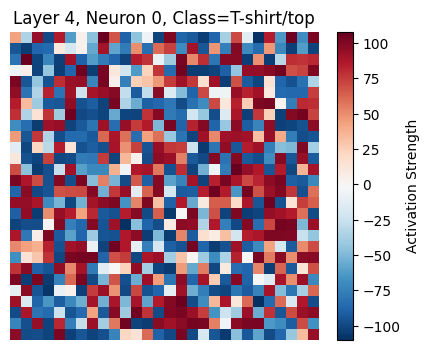

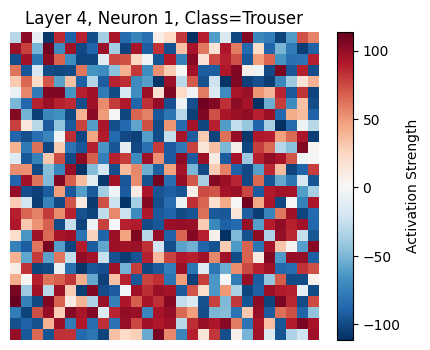

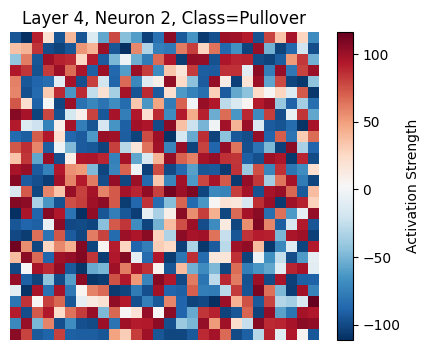

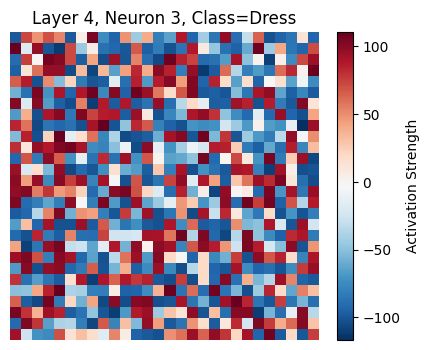

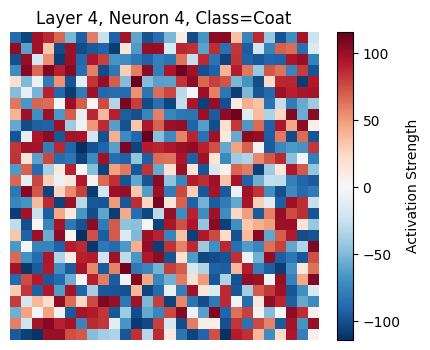

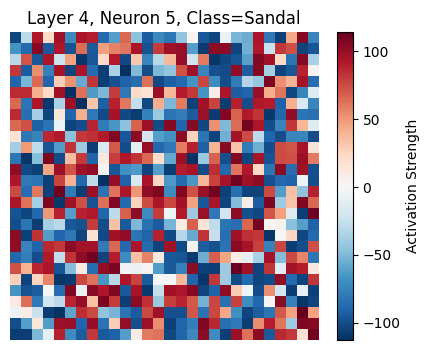

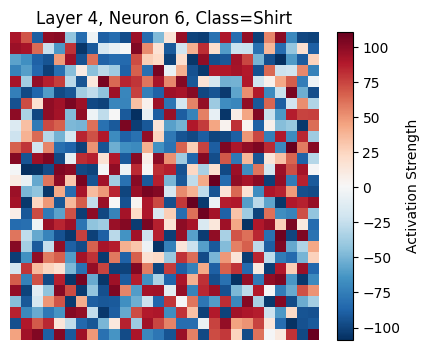

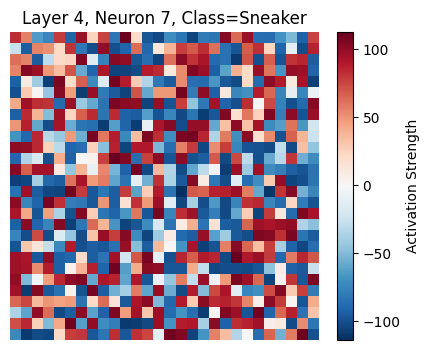

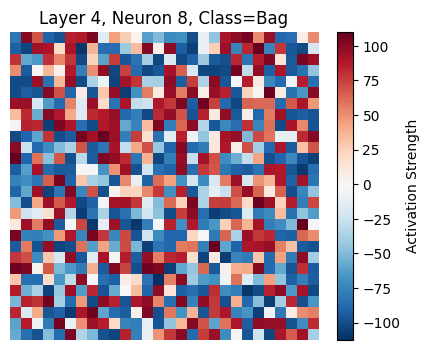

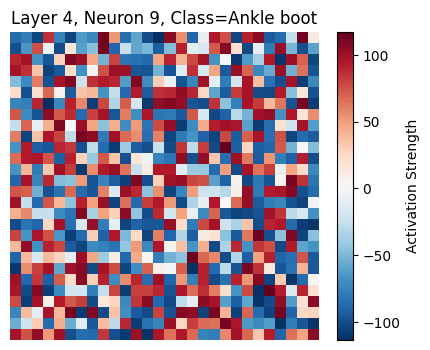

In [16]:
import matplotlib.pyplot as plt
def visualize_first_layer(model):
    weights = model.linear_relu_stack[0].weight.detach().numpy()
    
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[0]:
            ax.imshow(weights[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_deeper_layer(model, layer_idx, neuron_idx, num_iterations=1000):
    model.eval()
    
    # Create a random input image
    input_image = torch.randn(1, 28*28, requires_grad=True)
    optimizer = torch.optim.Adam([input_image], lr=0.1)
    
    for _ in range(num_iterations):
        optimizer.zero_grad()
        
        # Forward pass
        x = input_image
        for i, layer in enumerate(model.linear_relu_stack):
            x = layer(x)
            if i == layer_idx:
                break
        
        # Maximize the activation of the specified neuron
        loss = -x[0, neuron_idx]
        loss.backward()
        optimizer.step()
    
    # Reshape the optimized input
    visualized_pattern = input_image.detach().numpy().reshape(28, 28)
    
    # Create a diverging colormap
    plt.figure(figsize=(5, 4))
    im = plt.imshow(visualized_pattern, cmap='RdBu_r')
    plt.colorbar(im, label='Activation Strength')
    plt.title(f"Layer {layer_idx}, Neuron {neuron_idx}, Class={classes[neuron_idx]}")
    plt.axis('off')
    plt.show()

for i in range(10):
    visualize_deeper_layer(model,4,i)